# Reseach Topic: Predict Wage with Machline Methods
## What am I doing ?
For now, we predict salary with several models.

## Data
The source of data is NLSY97. The portal can be accessed from [here](https://www.nlsinfo.org/investigator/pages/search.jsp?s=NLSY97). The data set is pre-cleaned by STATA with around 4500 obervations each year from 2. Features include age, year of experience, gender, schooling, race, marital status, industry, region(not yet!!). 

## Run Some Models
Bofore running anything, we split the data into training set, validation set, test set. <br/> I am preparing to do the following models:
- Linear model (Panel Data Regression)
- Trees and Forests (Regression Trees, Random Forests and XGBoost)
- Neural Nets (Multilayer Perceptrons)

The performences of models will be compared in accuracy and R-square

## Further Thoughts
(Haven't done yet) We resample the data into previous years and the following years. Then we train the model on previous years data and test it on the data from the following years.

# Let's get started :D

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

'''
Read in Data
'''
data_path = './data/mincer.xlsx'
dat = pd.read_excel(data_path)
dat = dat.fillna(0)

In [2]:
global train
years = [i for i in range(2005,2011)]+[2013]+[2015]
dat_tmp = dat 
train, test =  train_test_split(dat_tmp, test_size = 0.2, random_state = 12)
y_train, X_train, y_test, X_test = train['lnwage'], train.iloc[:,4:], test['lnwage'], test.iloc[:,4:]

In [68]:
features = list(X_train.keys())
for i,f in enumerate(features,0):
    print((i,f))

(0, 'id')
(1, 'sex')
(2, 'schooling')
(3, 'year')
(4, 'marital_status')
(5, 'age')
(6, 'exp')
(7, 'exp2')
(8, 'exp3')
(9, 'race_1')
(10, 'race_2')
(11, 'race_3')
(12, 'industry_1')
(13, 'industry_2')
(14, 'industry_3')
(15, 'industry_4')
(16, 'industry_5')
(17, 'industry_6')
(18, 'industry_7')
(19, 'industry_8')
(20, 'industry_9')
(21, 'industry_10')
(22, 'industry_11')
(23, 'industry_12')
(24, 'industry_13')
(25, 'industry_14')
(26, 'industry_15')
(27, 'industry_16')
(28, 'industry_18')


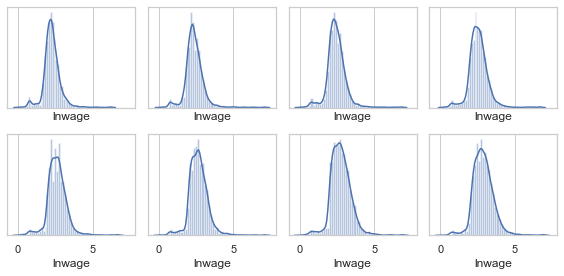

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
f, axes = plt.subplots(2, 4, figsize=(8, 4), sharex=True)

i,j = 0,0
for y in years:
    sns.distplot(dat[dat['year']==y]['lnwage'], ax = axes[j,i])
    if i < 3:
        i += 1
    else:
        i,j = 0,1 
plt.setp(axes, yticks=[])
plt.tight_layout()

## Define Models here

In [73]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import adam

def mincer(X_train, y_train,  X_test, y_test):
    regressor = LinearRegression()
    reg = regressor.fit(X_train,y_train)
    return evaluate(reg, X_train, X_test, y_train, y_test)

def trees(X_train, y_train, X_test, y_test, model="rf",max_depth=15):
    if  model == "gb":
        regressor = GradientBoostingRegressor(max_depth=5)
    else:
        regressor = RandomForestRegressor(max_depth, random_state=1)
    reg = regressor.fit(X_train, y_train)
    return evaluate(reg, X_train, X_test, y_train, y_test)


def tree(X_train, y_train, X_test, y_test):
    regressor = DecisionTreeRegressor()
    reg = regressor.fit(X_train, y_train)
    return evaluate(reg, X_train, X_test, y_train, y_test)

def nn(X_train, y_train, X_test, y_test, verbose = 1):
    model = Sequential()
    model.add(Dense(8, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal',activation='relu'))
    # model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    history = model.fit(X_train, y_train, epochs=10, batch_size = 50,  verbose = verbose, validation_split=0.10)
    
    return evaluate(model, X_train, X_test, y_train, y_test)

def evaluate(model, X_train, X_test, y_train, y_test):
    y_pred_in = np.array( model.predict(X_train) )
    y_pred_out = np.array( model.predict(X_test) )
    if y_pred_in.ndim >1:
        y_pred_in = y_pred_in.flatten()
        y_pred_out =  y_pred_out.flatten()

    r2_in = metrics.r2_score(y_train,y_pred_in)
    r2_out = metrics.r2_score(y_test,y_pred_out)
    mse_in = np.mean((y_pred_in - np.array(y_train))**2)
    mse_out = np.mean((y_pred_out - np.array( y_test) )**2 )

    return mse_in, mse_out, r2_in, r2_out

# Test 1: Comparasion Between the Models

## Tree

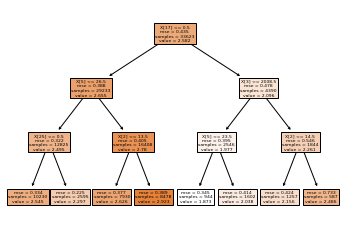

<Figure size 432x288 with 0 Axes>

In [15]:
from sklearn import tree
plt.figure()
regressor = DecisionTreeRegressor(max_depth=3)
reg = regressor.fit(X_train, y_train)
tree.plot_tree(reg, filled= True)
plt.show()
# plt.savefig('./image_output/tree.png')

## Random Forest

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Feature ranking:
1. feature 17 (0.207021)
2. feature 0 (0.194952)
3. feature 5 (0.166443)
4. feature 2 (0.127877)
5. feature 1 (0.053751)
6. feature 3 (0.040118)
7. feature 25 (0.039088)
8. feature 4 (0.035429)
9. feature 9 (0.021286)
10. feature 7 (0.018453)
11. feature 8 (0.018126)
12. feature 6 (0.017844)
13. feature 16 (0.009689)
14. feature 22 (0.008239)
15. feature 11 (0.007096)
16. feature 10 (0.005989)
17. feature 15 (0.005109)
18. feature 23 (0.004232)
19. feature 19 (0.003147)
20. feature 18 (0.003022)
21. feature 12 (0.002470)
22. feature 26 (0.002416)
23. feature 20 (0.001606)
24. feature 14 (0.001535)
25. feature 24 (0.001512)
26. feature 28 (0.001352)
27. feature 21 (0.001226)
28. feature 27 (0.000673)
29. feat

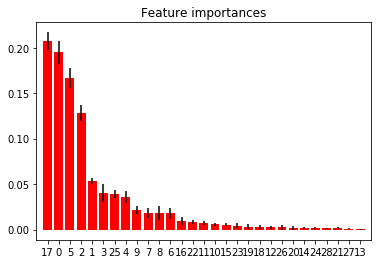

In [31]:
regressor = RandomForestRegressor(max_depth = 10, random_state=1)
forest = regressor.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
n_features = X_train.shape[1]
# n_features = 10
# Print the feature ranking
print("Feature ranking:")

for f in range(n_features ):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(n_features ), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(n_features), indices)
plt.xlim([-1, n_features])
plt.show()

## XGBoost

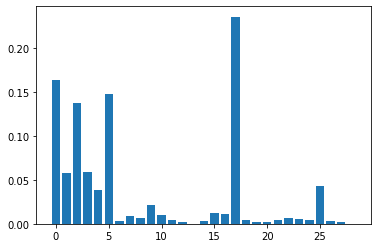

In [39]:
regressor = GradientBoostingRegressor(max_depth=5)
boost= regressor.fit(X_train, y_train)
importances = boost.feature_importances_
plt.bar(range(len(boost.feature_importances_)), boost.feature_importances_)
plt.show()

## Neural Net

In [64]:
model = Sequential()
model.add(Dense(128, input_dim=29, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size = 32,  verbose=1, validation_split=0.2)



Train on 26898 samples, validate on 6725 samples
Epoch 1/50
26898/26898 [==============================] - 1s 45us/step - loss: 20.1090 - mae: 1.5156 - val_loss: 1.3082 - val_mae: 0.8827
Epoch 2/50
26898/26898 [==============================] - 1s 35us/step - loss: 4.5076 - mae: 1.1408 - val_loss: 0.5612 - val_mae: 0.5677
Epoch 3/50
26898/26898 [==============================] - 1s 34us/step - loss: 0.8926 - mae: 0.6651 - val_loss: 0.6063 - val_mae: 0.5664
Epoch 4/50
26898/26898 [==============================] - 1s 34us/step - loss: 1.1887 - mae: 0.7476 - val_loss: 0.4112 - val_mae: 0.4572
Epoch 5/50
26898/26898 [==============================] - 1s 33us/step - loss: 0.8927 - mae: 0.6992 - val_loss: 0.5090 - val_mae: 0.5126
Epoch 6/50
26898/26898 [==============================] - 1s 34us/step - loss: 0.8435 - mae: 0.6657 - val_loss: 0.4995 - val_mae: 0.5024
Epoch 7/50
26898/26898 [==============================] - 1s 34us/step - loss: 0.5708 - mae: 0.5529 - val_loss: 0.4735 - val_mae

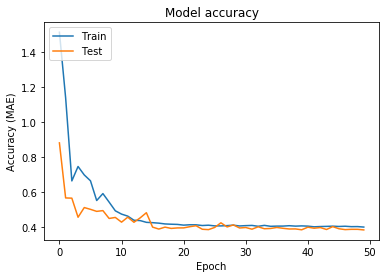

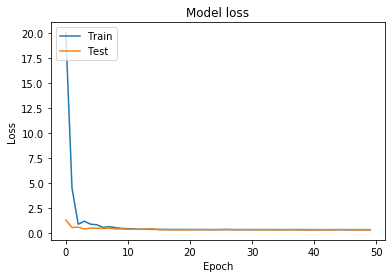

In [67]:
# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model accuracy')
plt.ylabel('Accuracy (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [69]:
# history.history

## Overall comparation Run 4 models and take the averges

In [241]:
iters = 5
res_linear, res_tree, res_rf, res_xgb, res_nn = np.array([0.0]*4),np.array([0.0]*4),np.array([0.0]*4),np.array([0.0]*4),np.array([0.0]*4)
for i in range(iters):
    print("foler:{}".format(i+1))
    res_linear += np.array(mincer(X_train, y_train, X_test, y_test) )

    res_tree += np.array( tree(X_train, y_train, X_test, y_test) )

    res_rf += np.array( trees(X_train, y_train, X_test, y_test ) )

    res_xgb += np.array( trees(X_train, y_train, X_test, y_test,model = "gb",max_depth=12) )

    res_nn += np.array( nn(X_train, y_train, X_test, y_test) )

tab1 = "Regression & "+" & ".join([str(round(num,5)) for num in res_linear/iters ]) + r" \\" + "\n" 
tab2 = "Regression Tree & "+" & ".join([str(round(num,5)) for num in res_tree/iters ]) + r" \\" + "\n"
tab3 = "Random Forest & "+" & ".join([str(round(num,5)) for num in res_rf/iters]) +r" \\" +  "\n"
tab4 = "XGBoost & "+" & ".join([str(round(num,5)) for num in res_xgb/iters]) + r" \\" + "\n"
tab5 = "Neural Networks & "+" & ".join([str(round(num,5)) for num in res_nn/iters]) + r" \\" + "\n"
print( tab1+ tab2+ tab3+ tab4+ tab5)

foler:1
Train on 30260 samples, validate on 3363 samples
Epoch 1/10
30260/30260 [==============================] - 1s 26us/step - loss: 1.1049 - mean_absolute_error: 1.1049 - val_loss: 0.5849 - val_mean_absolute_error: 0.5849
Epoch 2/10
30260/30260 [==============================] - 1s 19us/step - loss: 0.6312 - mean_absolute_error: 0.6312 - val_loss: 0.5716 - val_mean_absolute_error: 0.5716
Epoch 3/10
30260/30260 [==============================] - 1s 21us/step - loss: 0.5365 - mean_absolute_error: 0.5365 - val_loss: 0.4645 - val_mean_absolute_error: 0.4645
Epoch 4/10
30260/30260 [==============================] - 1s 20us/step - loss: 0.5052 - mean_absolute_error: 0.5052 - val_loss: 0.6499 - val_mean_absolute_error: 0.6499
Epoch 5/10
30260/30260 [==============================] - 1s 21us/step - loss: 0.4721 - mean_absolute_error: 0.4721 - val_loss: 0.5962 - val_mean_absolute_error: 0.5962
Epoch 6/10
30260/30260 [==============================] - 1s 20us/step - loss: 0.4441 - mean_absol

# Test 2: Performance Over the Years
Now I am running the models over the years (2005 to 2011, 2013, 2015). 

In [91]:
years = [i for i in range(2005,2011)]+[2013]+[2015]
res={}
res['ols'],res['rf'],res['gbm'],res['trees'], res['nets'] = [],[],[],[],[]
for y in years:
    print("---------current test year is {}---------".format(y) )
    data = dat[dat['year']==y]
    train, test =  train_test_split(data, test_size = 0.25, random_state = 12)
    y_train, X_train, y_test, X_test = train['lnwage'], train.iloc[:,4:], test['lnwage'], test.iloc[:,4:]
    res['ols'].append( mincer(X_train, y_train,  X_test, y_test) )
    res['rf'].append( trees(X_train, y_train, X_test, y_test, model= "rf",max_depth=5) )
    res['gbm'].append( trees(X_train, y_train, X_test, y_test, model= "gb",max_depth=5) )
    res['nets'].append(nn(X_train, y_train, X_test, y_test, verbose = 0))
    

---------current test year is 2005---------
---------current test year is 2006---------
---------current test year is 2007---------
---------current test year is 2008---------
---------current test year is 2009---------
---------current test year is 2010---------
---------current test year is 2013---------
---------current test year is 2015---------


MSE, training set
MSE, testing set
$R^2$, training set
$R^2$, testing set


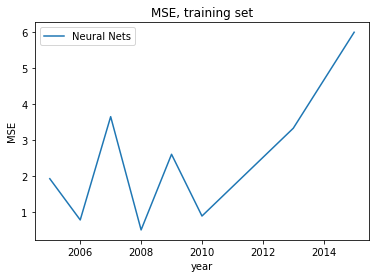

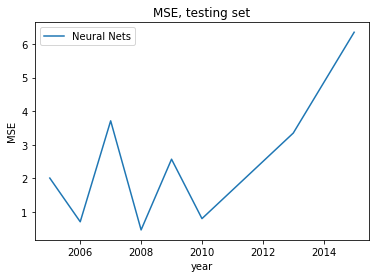

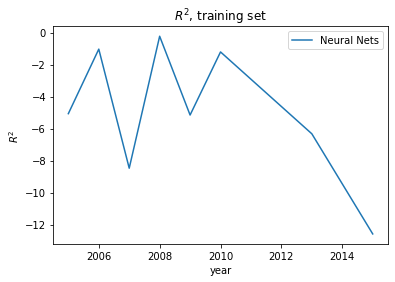

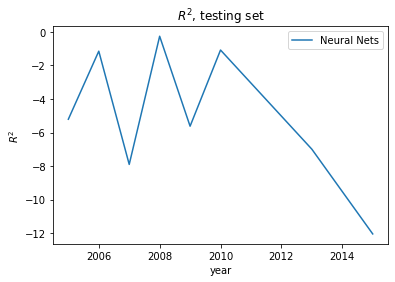

In [143]:
import matplotlib.pyplot as plt
ylabels = ['MSE','MSE',r'$R^2$',r'$R^2$']
titles= ['MSE, training set',
         'MSE, testing set',
        r'$R^2$, training set',
        r'$R^2$, testing set'
        ]
for i in range(4):
    print(titles[i])
    # plt.plot(years, np.array(res['ols'])[:,i], label = "Mincer")
    # plt.plot(years, np.array(res['rf'])[:,i], label = "Random Forests")
    # plt.plot(years, np.array(res['gbm'])[:,i], label = "Gradient Boosting Machine")
    plt.plot(years, np.array(res['nets'])[:,i], label = "Neural Nets")
    plt.ylabel(ylabels[i])
    plt.xlabel('year')
    plt.title(titles[i])
    plt.legend()
    plt.show()

0 0 0
1 1 0
2 2 0
3 1 1


In [83]:
np.array(res['ols'])[:,0]

array([0.25554364, 0.32051109, 0.31725352, 0.32517996, 0.34175659,
       0.31455867, 0.39489741, 0.35122423])